In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from util import get_data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# from sklearn import tree

seed = 42

In [3]:
df = pd.read_pickle("data/job_table_r_preproc.pkl")
labels = df["job_state"]
df = df.drop(["job_state", "submit_time"], axis=1)
data = df

df.head()

,user_id,group_id,name,command,partition,cpus_per_task,num_tasks,priority,qos,time_limit,year_month,req_cpu,req_mem,req_node,req_billing,req_gres/gpu
0,32171,25200,77949,62668,3,4,1,87034,4,10,0,4,246000,1,4,0
1,32171,25200,77949,62782,3,4,1,85884,4,10,0,4,246000,1,4,0
2,32171,25200,77949,62085,3,4,1,115982,4,10,0,4,246000,1,4,0
3,32152,25200,30918,51406,3,32,8,80216,4,360,0,256,230000,1,256,1
4,32171,25200,77949,62678,3,4,1,86934,4,10,0,4,246000,1,4,0


In [4]:
labels.head()

0    COMPLETED
1    COMPLETED
2    COMPLETED
3       FAILED
4    COMPLETED
Name: job_state, dtype: object

We only consider 2 classes:
 - **0**: for completed job
 - **1**: for those failed
 
To do so, we firstly convert other failure classes into **FAILED**.

In [5]:
# print("Old labels: ", np.unique(labels))

labels[labels == "OUT_OF_MEMORY"] = "FAILED"
labels[labels == "TIMEOUT"] = "FAILED"

# print("New labels: ", list(np.unique(labels)))

# Encode labels into class 0 and 1
lab_enc = LabelEncoder()
lab_enc.fit(labels)
unique_labels = lab_enc.classes_
num_classes = len(unique_labels)

# print(f"Old values: {labels[:5]} ...")
labels = lab_enc.transform(labels)
# print(f"New values: {labels[:5]} ...")


In [6]:
labels

array([0, 0, 0, ..., 1, 0, 0])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    data, labels, train_size=0.7, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, train_size=0.8, random_state=seed)

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

print(f"train data shape: {x_train.shape}")
print(f"val data shape: {x_val.shape}")
print(f"test data shape: {x_test.shape}")
print(f"train labels shape: {len(y_train)}")
print(f"val labels shape: {len(y_val)}")
print(f"test labels shape: {len(y_test)}")


train data shape: (546095, 16)
val data shape: (136524, 16)
test data shape: (292551, 16)
train labels shape: 546095
val labels shape: 136524
test labels shape: 292551


In [8]:
# Create a random forest classifier
rf = RandomForestClassifier(random_state=seed)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [9]:
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
y_pred = rf.predict(x_train)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_train, y_pred, average="binary")
print(f"F1 on test set: {f1}")
print(f"Recall on test set: {recall}")
print(f"Precision on test set: {precision}")


F1 on test set: 0.9715304124342186
Recall on test set: 0.9647707592744508
Precision on test set: 0.9783854567863195


In [11]:
y_pred = rf.predict(x_test)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary")
print(f"F1 on test set: {f1}")
print(f"Recall on test set: {recall}")
print(f"Precision on test set: {precision}")

F1 on test set: 0.8442504061267115
Recall on test set: 0.8346621544109212
Precision on test set: 0.8540615095668506


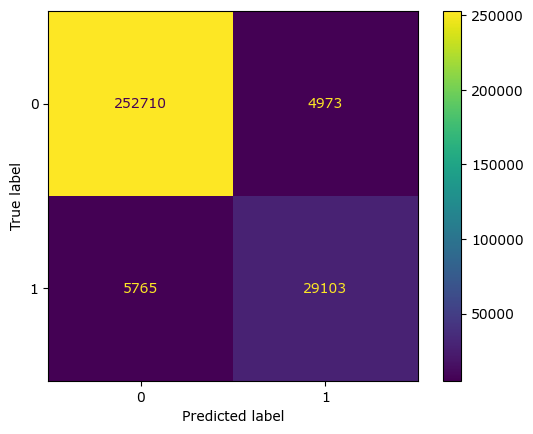

In [12]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Setting hyperparameters to reach better performances

In [13]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=110, stop=200, num=10)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(30, 100, num=8)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 3]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf_search = RandomForestClassifier(random_state=seed)

rf_random_param = RandomizedSearchCV(estimator=rf_search, param_distributions=random_grid,
                               n_iter=15, cv=3, verbose=2, random_state=seed, n_jobs=-1)

print(rf_random_param)

rf_random_param.fit(x_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [30, 40, 50, 60, 70, 80,
                                                      90, 100, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3],
                                        'n_estimators': [110, 120, 130, 140,
                                                         150, 160, 170, 180,
                                                         190, 200]},
                   random_state=42, verbose=2)
Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [30, 40, 50, 60, 70, 80,
                                                      90, 100, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3],
                                        'n_estimators': [110, 120, 130, 140,
                                                         150, 160, 170, 180,
                                                         190, 200]},
                   random_state=42, verbose=2)

In [ ]:
rf_random_param.best_params_

{'n_estimators': 110,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [ ]:
y_pred = rf_random_param.predict(x_test)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary")
print(f"F1 on test set: {f1}")
print(f"Recall on test set: {recall}")
print(f"Precision on test set: {precision}")


F1 on test set: 0.8476040269445632
Recall on test set: 0.8245956177584031
Precision on test set: 0.8719332827899924


prova con dataset senza features che hanno distribuzione schifosa

In [ ]:
df.head()

,user_id,group_id,name,command,partition,cpus_per_task,num_tasks,priority,qos,time_limit,year_month,req_cpu,req_mem,req_node,req_billing,req_gres/gpu
0,32171,25200,77949,62668,3,4,1,87034,4,10,0,4,246000,1,4,0
1,32171,25200,77949,62782,3,4,1,85884,4,10,0,4,246000,1,4,0
2,32171,25200,77949,62085,3,4,1,115982,4,10,0,4,246000,1,4,0
3,32152,25200,30918,51406,3,32,8,80216,4,360,0,256,230000,1,256,1
4,32171,25200,77949,62678,3,4,1,86934,4,10,0,4,246000,1,4,0


In [ ]:
new_data = df.drop(["group_id", "partition", "cpus_per_task", "num_tasks", "priority", "req_mem", "req_node", "req_billing", "req_gres/gpu", "qos", "time_limit", "year_month"], axis=1)

In [ ]:
new_data.head()

,user_id,name,command,req_cpu
0,32171,77949,62668,4
1,32171,77949,62782,4
2,32171,77949,62085,4
3,32152,30918,51406,256
4,32171,77949,62678,4


In [ ]:
new_data["req_cpu"].unique()



array([    4,   256,     1,   128,    32,     2,   512,  1024,    16,
          96,    64,     8,  1536,  3072,  1280,   640,    24,  1152,
        4096,    48,    10,   384,     6,   144,  2048,  6144,    12,
         192,    34,   768,    20, 16384, 32768,  2560,  8192,  3840,
        6400,    80,    28,    56,    72,    36,     3,   248, 13824,
          62,   200,   320,   140,   400,    45,   160,  1920,    54,
          18,    65,   130,    40,    30,   896,     7,    60,    15,
         120,     9,   100,   480,  1296,  2592,  1728,   864,  3200,
        2304,  5120,  7680,   288,  9216,  4608, 10240,    31,   224,
        1792,  3584,  4444,     5, 18432,   240,   576,   324,   180,
         136,   832,   432,   112,  1664,  8704, 31744,  2176,  4224,
         360,  6016,   108, 20480,   448,  1408, 24576,  2880,    90,
       16128, 12544,  6912, 32256,   208,   216,    58,    42,   124,
          27,    21,   116,    75,   540,  7168, 14336,  8960,  8320,
       65536,   496,

In [ ]:
count = new_data["req_cpu"].value_counts()

In [ ]:
dict_count = count.to_dict()

In [ ]:
dict_count

{128: 306694,
 4: 209649,
 24: 196635,
 16: 69015,
 1: 44801,
 32: 41583,
 64: 33498,
 256: 17891,
 2: 8536,
 2048: 7736,
 512: 6921,
 8: 6691,
 1024: 4082,
 1280: 2158,
 384: 2109,
 1152: 1603,
 4096: 1398,
 192: 1275,
 96: 1091,
 48: 1008,
 640: 974,
 768: 838,
 12: 825,
 40: 654,
 1920: 608,
 6: 508,
 36: 439,
 20: 439,
 30: 417,
 72: 388,
 18: 362,
 16384: 355,
 2560: 274,
 5: 256,
 7: 237,
 8192: 231,
 1536: 220,
 896: 195,
 80: 184,
 3200: 168,
 1792: 145,
 6144: 130,
 6400: 122,
 32768: 112,
 3072: 108,
 5120: 102,
 160: 100,
 832: 80,
 7680: 60,
 90: 58,
 3: 57,
 4608: 56,
 16128: 55,
 320: 53,
 576: 49,
 28: 49,
 10: 48,
 2304: 46,
 60: 45,
 33: 41,
 3840: 40,
 120: 36,
 180: 36,
 66: 32,
 1664: 32,
 400: 31,
 56: 26,
 15: 23,
 9: 23,
 144: 23,
 288: 21,
 480: 19,
 9216: 18,
 13824: 18,
 864: 15,
 1408: 14,
 18432: 14,
 99: 14,
 32256: 14,
 100: 13,
 3584: 12,
 960: 11,
 12800: 11,
 14336: 11,
 10240: 11,
 1296: 10,
 132: 10,
 504: 10,
 224: 9,
 240: 9,
 8320: 8,
 129: 7,
 691

In [ ]:
dict_count.keys()


dict_keys([128, 4, 24, 16, 1, 32, 64, 256, 2, 2048, 512, 8, 1024, 1280, 384, 1152, 4096, 192, 96, 48, 640, 768, 12, 40, 1920, 6, 36, 20, 30, 72, 18, 16384, 2560, 5, 7, 8192, 1536, 896, 80, 3200, 1792, 6144, 6400, 32768, 3072, 5120, 160, 832, 7680, 90, 3, 4608, 16128, 320, 576, 28, 10, 2304, 60, 33, 3840, 120, 180, 66, 1664, 400, 56, 15, 9, 144, 288, 480, 9216, 13824, 864, 1408, 18432, 99, 32256, 100, 3584, 960, 12800, 14336, 10240, 1296, 132, 504, 224, 240, 8320, 129, 6912, 360, 216, 16000, 14, 27, 8960, 252, 12288, 6016, 20480, 500, 200, 124, 248, 2592, 108, 250, 58, 7168, 1728, 54, 432, 19200, 448, 62, 2176, 34, 176, 32000, 84, 26, 4444, 720, 600, 3712, 321, 25600, 5760, 1284, 75, 264, 130, 324, 31, 136, 112, 8704, 31744, 4224, 24576, 2880, 65, 140, 12544, 208, 42, 21, 116, 540, 45, 65536, 496, 5376])

In [ ]:
dict_count.values()

dict_values([306694, 209649, 196635, 69015, 44801, 41583, 33498, 17891, 8536, 7736, 6921, 6691, 4082, 2158, 2109, 1603, 1398, 1275, 1091, 1008, 974, 838, 825, 654, 608, 508, 439, 439, 417, 388, 362, 355, 274, 256, 237, 231, 220, 195, 184, 168, 145, 130, 122, 112, 108, 102, 100, 80, 60, 58, 57, 56, 55, 53, 49, 49, 48, 46, 45, 41, 40, 36, 36, 32, 32, 31, 26, 23, 23, 23, 21, 19, 18, 18, 15, 14, 14, 14, 14, 13, 12, 11, 11, 11, 11, 10, 10, 10, 9, 9, 8, 7, 6, 6, 5, 5, 5, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
for k,v in dict_count.items():
    if v/new_data.shape[0] > 0.005:
        dict_count[k] = k
    else: 
        dict_count[k] = 0

In [ ]:
dict_count

{128: 128,
 4: 4,
 24: 24,
 16: 16,
 1: 1,
 32: 32,
 64: 64,
 256: 256,
 2: 2,
 2048: 2048,
 512: 512,
 8: 8,
 1024: 0,
 1280: 0,
 384: 0,
 1152: 0,
 4096: 0,
 192: 0,
 96: 0,
 48: 0,
 640: 0,
 768: 0,
 12: 0,
 40: 0,
 1920: 0,
 6: 0,
 36: 0,
 20: 0,
 30: 0,
 72: 0,
 18: 0,
 16384: 0,
 2560: 0,
 5: 0,
 7: 0,
 8192: 0,
 1536: 0,
 896: 0,
 80: 0,
 3200: 0,
 1792: 0,
 6144: 0,
 6400: 0,
 32768: 0,
 3072: 0,
 5120: 0,
 160: 0,
 832: 0,
 7680: 0,
 90: 0,
 3: 0,
 4608: 0,
 16128: 0,
 320: 0,
 576: 0,
 28: 0,
 10: 0,
 2304: 0,
 60: 0,
 33: 0,
 3840: 0,
 120: 0,
 180: 0,
 66: 0,
 1664: 0,
 400: 0,
 56: 0,
 15: 0,
 9: 0,
 144: 0,
 288: 0,
 480: 0,
 9216: 0,
 13824: 0,
 864: 0,
 1408: 0,
 18432: 0,
 99: 0,
 32256: 0,
 100: 0,
 3584: 0,
 960: 0,
 12800: 0,
 14336: 0,
 10240: 0,
 1296: 0,
 132: 0,
 504: 0,
 224: 0,
 240: 0,
 8320: 0,
 129: 0,
 6912: 0,
 360: 0,
 216: 0,
 16000: 0,
 14: 0,
 27: 0,
 8960: 0,
 252: 0,
 12288: 0,
 6016: 0,
 20480: 0,
 500: 0,
 200: 0,
 124: 0,
 248: 0,
 2592: 0,
 108:

In [ ]:
new_data["req_cpu"] = new_data["req_cpu"].replace(dict_count)

In [ ]:
new_data["req_cpu"].value_counts()

req_cpu
128     306694
4       209649
24      196635
16       69015
1        44801
32       41583
64       33498
0        25520
256      17891
2         8536
2048      7736
512       6921
8         6691
Name: count, dtype: int64

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    new_data, labels, train_size=0.7, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, train_size=0.8, random_state=seed)

print(f"train data shape: {x_train.shape}")
print(f"val data shape: {x_val.shape}")
print(f"test data shape: {x_test.shape}")
print(f"train labels shape: {len(y_train)}")
print(f"val labels shape: {len(y_val)}")
print(f"test labels shape: {len(y_test)}")


train data shape: (546095, 4)
val data shape: (136524, 4)
test data shape: (292551, 4)
train labels shape: 546095
val labels shape: 136524
test labels shape: 292551


In [ ]:
# Create a random forest classifier
rf = RandomForestClassifier(random_state=seed)
rf.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf.predict(x_test)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary")
print(f"F1 on test set: {f1}")
print(f"Recall on test set: {recall}")
print(f"Precision on test set: {precision}")

F1 on test set: 0.7245710919667181
Recall on test set: 0.7055466330159459
Precision on test set: 0.7446499379483609


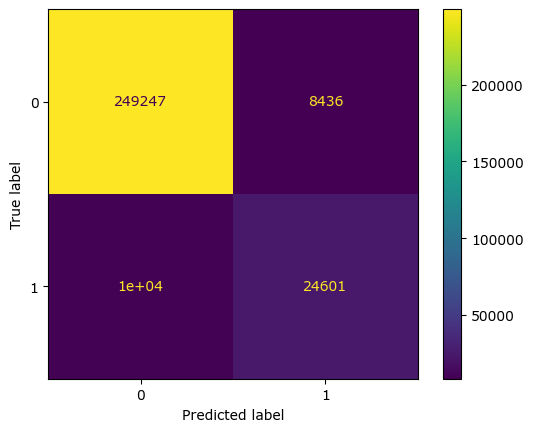

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

la f1 prec e recall droppano, ma non in maniera significativa e sostanziale. per cui penso che le features rimosse siano poco informative al momento, ma possono avere del potenziale se lavorate in maniera corretta

In [ ]:
new_data_temp = df.drop(["group_id", "partition", "cpus_per_task", "num_tasks", "priority", "req_mem",
                   "req_node", "req_billing", "req_gres/gpu", "qos", "time_limit", "year_month"], axis=1)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    new_data_temp, labels, train_size=0.7, random_state=seed)

# Create a random forest classifier
rf = RandomForestClassifier(random_state=seed)
rf.get_params()

rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary")
print(f"F1 on test set: {f1}")
print(f"Recall on test set: {recall}")
print(f"Precision on test set: {precision}")

F1 on test set: 0.722624301265078
Recall on test set: 0.7044281289434439
Precision on test set: 0.7417854554240154


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    new_data, labels, train_size=0.7, random_state=seed)

# Create a random forest classifier
rf = RandomForestClassifier(random_state=seed)
rf.get_params()

rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary")
print(f"F1 on test set: {f1}")
print(f"Recall on test set: {recall}")
print(f"Precision on test set: {precision}")


F1 on test set: 0.7219614133714001
Recall on test set: 0.7034817024205575
Precision on test set: 0.741438200888674


In [ ]:
from sklearn.tree import convert_to_graphviz
import graphviz

graphviz.Source(export_graphviz(rf.estimators_[0]))


ImportError: cannot import name 'convert_to_graphviz' from 'sklearn.tree' (c:\Users\LV4\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\__init__.py)

In [ ]:
fn = new_data.columns
cn = ["0", "1"]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=800)
tree.plot_tree(rf.estimators_[0],
               feature_names=fn,
               class_names=cn,
               filled=True)
# fig.savefig('rf_individualtree.png')


[Text(0.5099951193367693, 0.9925373134328358, 'req_cpu <= 12.0\ngini = 0.211\nsamples = 431472\nvalue = [600588, 82031]\nclass = 0'),
 Text(0.18263818753475097, 0.9776119402985075, 'req_cpu <= 1.5\ngini = 0.351\nsamples = 130809\nvalue = [159808, 47041]\nclass = 0'),
 Text(0.10086793864982645, 0.9626865671641791, 'command <= 54739.5\ngini = 0.446\nsamples = 31218\nvalue = [32805, 16596]\nclass = 0'),
 Text(0.05873979669947471, 0.9477611940298507, 'user_id <= 31306.0\ngini = 0.478\nsamples = 18046\nvalue = [17233, 11288]\nclass = 0'),
 Text(0.02824585810050883, 0.9328358208955224, 'command <= 14194.0\ngini = 0.454\nsamples = 11037\nvalue = [11312, 6029]\nclass = 0'),
 Text(0.012268839729912377, 0.917910447761194, 'command <= 10437.5\ngini = 0.273\nsamples = 6263\nvalue = [8224, 1604]\nclass = 0'),
 Text(0.0070376084797703865, 0.9029850746268657, 'user_id <= 29357.5\ngini = 0.333\nsamples = 4658\nvalue = [5775, 1547]\nclass = 0'),
 Text(0.003581695698614582, 0.8880597014925373, 'user_id 

Error in callback <function flush_figures at 0x000001FED793CCA0> (for post_execute):


KeyboardInterrupt: 